In [1]:
import transportation_tutorials as tt

# Creating Static Maps

In this gallery, we will demonstrate the creation of a variety of static maps.
Static maps are a good choice for analytical work that will be published in
a static document (i.e., on paper, or as a PDF).  In these examples,
we will demonstrate creating static maps using [GeoPandas](http://geopandas.org) 
and [Matplotlib](https://matplotlib.org).

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

We'll begin by loading the TAZ and MAZ shapefiles, filtering them to a restricted study area,
and defining the center point.

In [3]:
xmin = 905712
ymin = 905343
taz = gpd.read_file(tt.data('SERPM8-TAZSHAPE')).cx[xmin:, ymin:]
maz = gpd.read_file(tt.data('SERPM8-MAZSHAPE')).cx[xmin:, ymin:]
center = (945495, 941036)

## Simple Map

Simple maps showing the geographic data contained in a GeoDataFrame can be created
using the ``plot`` method.

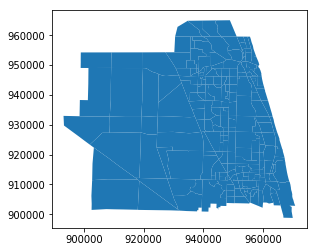

In [4]:
ax = taz.plot()

The map can be styled to be more legible by passing some styling arguments to the ``plot`` method.

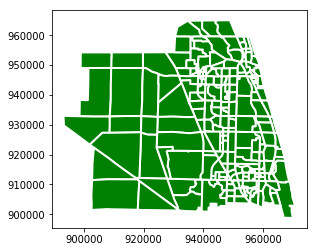

In [5]:
ax = taz.plot(color='green', linewidth=2, edgecolor='white')

The return value of the ``plot`` method the matplotlib AxesSubplot object
on which the map has been drawn.  A new plot is created by default when the
``plot`` method is called, but it this can be overridden by passing in to the 
function an existing AxesSubplot.  This allows drawing multiple different 
geographic data sets on the same map.  For example, we can draw TAZ's and MAZ's
together.

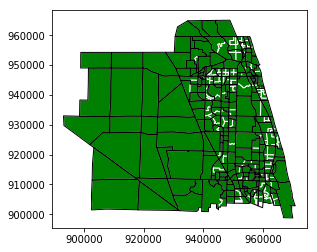

In [6]:
ax = maz.plot(linewidth=1,  color='green', edgecolor='white')
ax = taz.plot(ax=ax, color=(0,0,0,0), linewidth=1, edgecolor='black')

The ability to reuse or modify the AxesSubplot object unlocks all
the usual capabilties of the matplotlib package.  We can use the typical 
matplotlib tools for figure creation and manipulation to customize the 
map as desired, including changing labels, borders, fonts, etc.
For example:

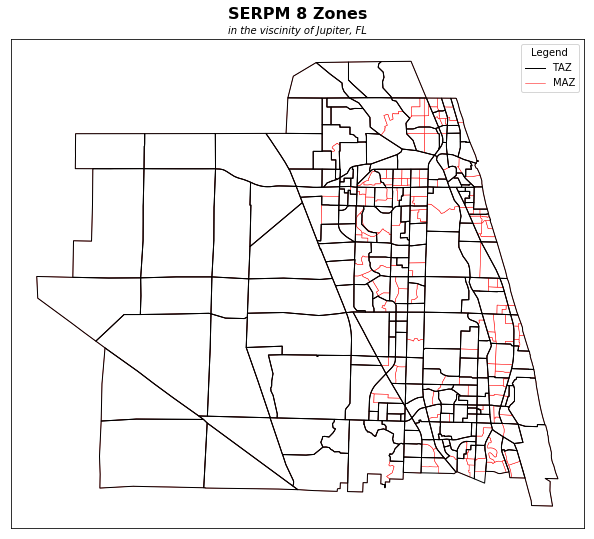

In [7]:
fig, ax = plt.subplots(figsize=(12,9))
ax.axis('on')      # do show axis as a frame
ax.set_xticks([])  # but no tick marks
ax.set_yticks([])  # one either axis
ax.set_title("SERPM 8 Zones", fontweight='bold', fontsize=16, pad=20)
ax.annotate('in the viscinity of Jupiter, FL', 
            xy=(0.5, 1.0), xycoords='axes fraction', 
            xytext=(0, 5), textcoords='offset points',
            horizontalalignment='center',
            fontstyle='italic')
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', linewidth=1, label='TAZ'),
    Line2D([0], [0], color='red', linewidth=0.5, label='MAZ'),
]
ax.legend(handles=legend_elements, title='Legend')
ax = maz.plot(ax=ax, linewidth=0.5,  color='white', edgecolor='red', label='MAZ')
ax = taz.plot(ax=ax, color=(0,0,0,0), linewidth=1, edgecolor='black')

## Mapping Data

One of the input files for SERPM 8 is a MAZ-level demographics file.
The file for the 2015 base year is included in the tutorial data, and 
we can load it with the `read_csv` function.

In [8]:
mazd = pd.read_csv(tt.data('SERPM8-MAZDATA', '*.csv'))

Use `info` to see a summary of the DataFrame.

In [9]:
mazd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12022 entries, 0 to 12021
Data columns (total 76 columns):
mgra                            12022 non-null int64
TAZ                             12022 non-null int64
HH                              12022 non-null int64
POP                             12022 non-null int64
emp_self                        12022 non-null int64
emp_ag                          12022 non-null int64
emp_const_non_bldg_prod         12022 non-null int64
emp_const_non_bldg_office       12022 non-null int64
emp_utilities_prod              12022 non-null int64
emp_utilities_office            12022 non-null int64
emp_const_bldg_prod             12022 non-null int64
emp_const_bldg_office           12022 non-null int64
emp_mfg_prod                    12022 non-null int64
emp_mfg_office                  12022 non-null int64
emp_whsle_whs                   12022 non-null int64
emp_trans                       12022 non-null int64
emp_retail                      12022 non-n

We can join the demographics table to the shape file we loaded previously,
to enable some visualizations on this data.  This can be done with the
``merge`` method of DataFrames.

In [10]:
maz1 = maz.merge(mazd, how='left', left_on='MAZ', right_on='mgra')

## Choropleth Maps

A [choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) is a map with areas colored, 
shaded, or patterned in proportion to some measured value for the region displayed. This kind of
map is commonly used to display things like population density.

A GeoDataFrame can be used to create a choropleth map simply by passing a column name to
the ``plot`` method, where the named column contains the data to be displayed.

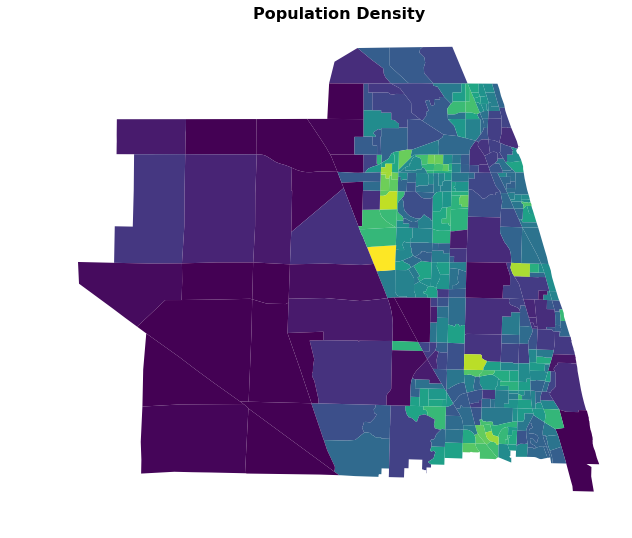

In [11]:
fig, ax = plt.subplots(figsize=(12,9))
ax.axis('off') # don't show axis
ax.set_title("Population Density", fontweight='bold', fontsize=16)
ax = maz1.plot(ax=ax, column='PopDen')

You can also add a legend easily.

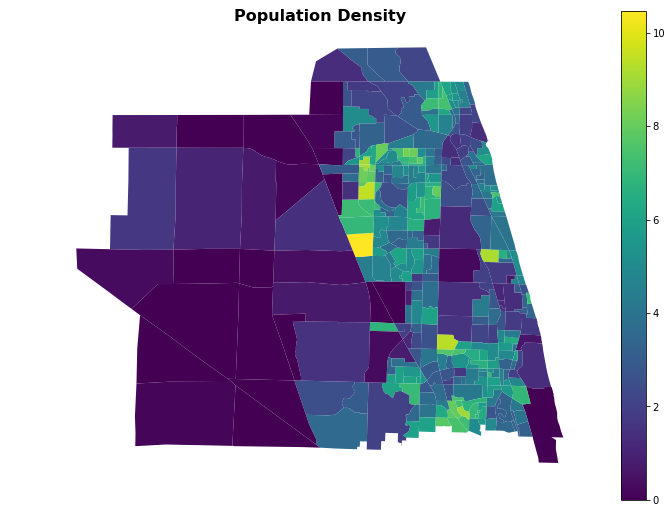

In [12]:
fig, ax = plt.subplots(figsize=(12,9))
ax.axis('off') # don't show axis
ax.set_title("Population Density", fontweight='bold', fontsize=16)
ax = maz1.plot(ax=ax, column='PopDen', legend=True)

Or change the colors, by giving a ``cmap`` argument.  Any 
[named colormap](https://matplotlib.org/tutorials/colors/colormaps.html)
from matplotlib can be used.

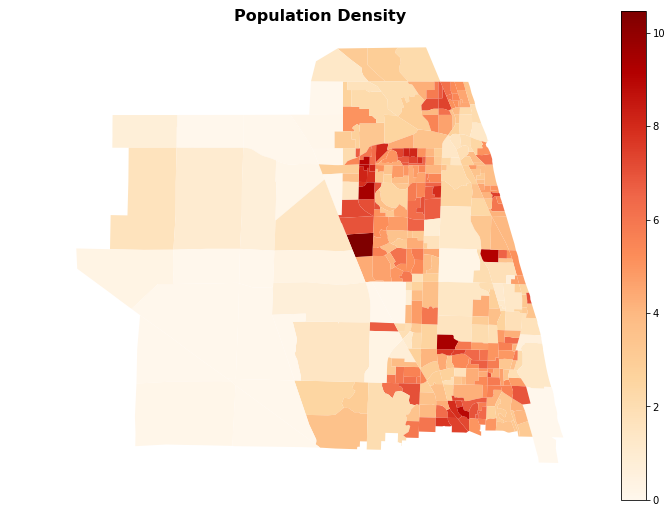

In [13]:
fig, ax = plt.subplots(figsize=(12,9))
ax.axis('off') # don't show axis
ax.set_title("Population Density", fontweight='bold', fontsize=16)
ax = maz1.plot(ax=ax, column='PopDen', legend=True, cmap='OrRd')

### Adding a Background

If we would like some additional context for the map, we can add a background layer with some
familiar map content.  To do so, we will need to get some map tiles (rendered map pieces), and we can use
[contextily](https://github.com/darribas/contextily) to help automate this.

In [14]:
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    
    attribution_txt = "Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL."
    ax.annotate(
        attribution_txt,
        xy=(1.0, 0.0), xycoords='axes fraction',
        xytext=(0, -10), textcoords='offset points',
        horizontalalignment='right',
        fontstyle='italic',
        fontsize=8,
    )

    return ax

Web map tiles are typically provided in
[Web Mercator](https://en.wikipedia.org/wiki/Web_Mercator)
[EPSG 3857](https://epsg.io/3857), so we need to make sure to convert
our data first to the same CRS to combine our polygons and background tiles
in the same map.

In [15]:
maz2 = maz1.to_crs(epsg=3857)

Then we can create the map.  We set the ``alpha`` (opacity) of the choropleth
plot itself to be only 0.6, so we can see the map tile detail underneath the 
colors.

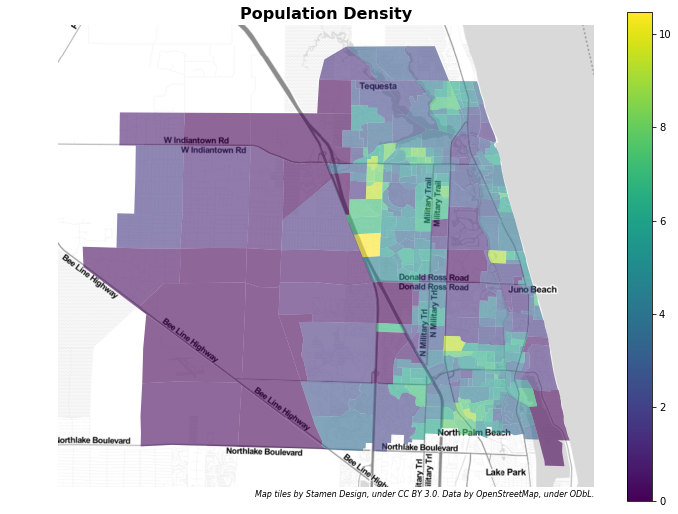

In [16]:
fig, ax = plt.subplots(figsize=(12,9))
ax.axis('off') # don't show axis
ax.set_title("Population Density", fontweight='bold', fontsize=16)
ax = maz2.plot(ax=ax, alpha=0.6, linewidth=0, cmap='viridis', column='PopDen', legend=True)
ax = add_basemap(ax, zoom=12, url=ctx.sources.ST_TONER_LITE)

## Dot Density Map

For certain kinds of data, it might make sense to plot a dot density map instead 
of a choropleth.

We'll use some code from the tutorials package to generate a dot density map
the shows population density in each MAZ.

In [17]:
tt.show_file(tt.tools.point_map)

The ``generate_points_in_areas`` function above will allow us to generate a
set of point to plot, filling in the dot density map.

In [18]:
random_points = tt.tools.point_map.generate_points_in_areas(maz1, values='POP', points_per_unit=20,)

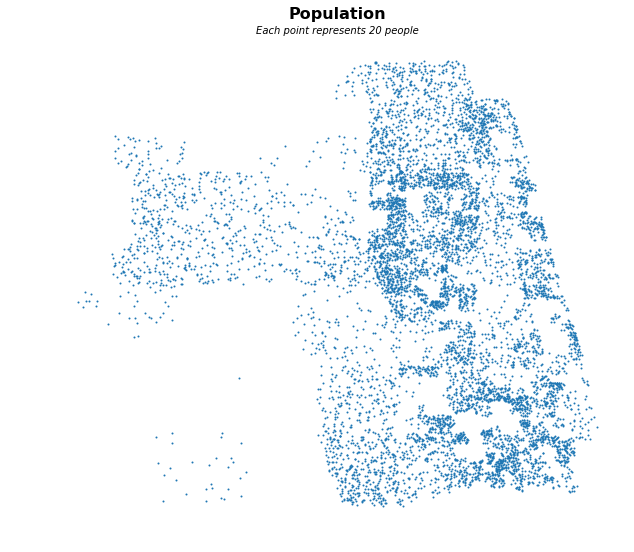

In [19]:
fig, ax = plt.subplots(figsize=(12,9))
ax.axis('off') # don't show axis
ax.set_title("Population", fontweight='bold', fontsize=16, pad=20)
ax.annotate('Each point represents 20 people', 
            xy=(0.5, 1.0), xycoords='axes fraction', 
            xytext=(0, 5), textcoords='offset points',
            horizontalalignment='center',
            fontstyle='italic')
ax = random_points.plot(ax=ax, markersize=1)

Dot density maps render very nicely on top of the [Stamen Toner Light](http://maps.stamen.com/toner-lite/) tiles.

In [20]:
emp_points = tt.tools.point_map.generate_points_in_areas(maz2, values='emp_total', points_per_unit=25)

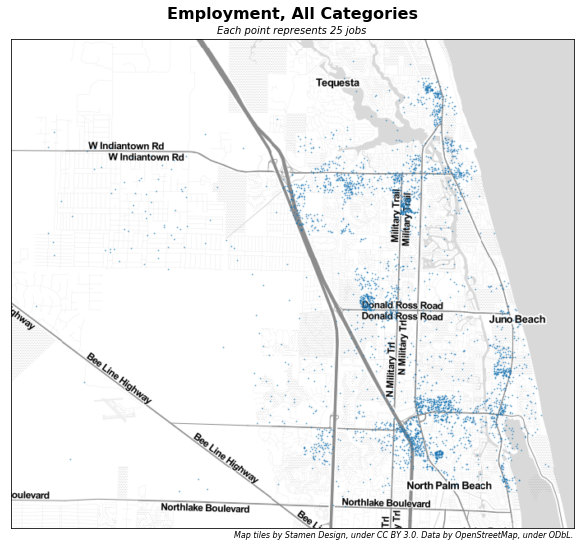

In [21]:
fig, ax = plt.subplots(figsize=(12,9))
ax.axis('on')      # do show axis as a frame
ax.set_xticks([])  # but no tick marks
ax.set_yticks([])  # one either axis
ax.set_title("Employment, All Categories", fontweight='bold', fontsize=16, pad=20)
ax = emp_points.plot(ax=ax, markersize=1, alpha=0.33)
ax.annotate('Each point represents 25 jobs', 
            xy=(0.5, 1.0), xycoords='axes fraction', 
            xytext=(0, 5), textcoords='offset points',
           horizontalalignment='center',
           fontstyle='italic')
ax = add_basemap(ax, zoom=12, url=ctx.sources.ST_TONER_LITE)


It is also possible to plot multiple different sets of dot density data
on the same map.  In the following example, we pull out retail and healthcare
employment, and plot those in different colors.

In [22]:
i = 'retail'
j = 'health'
i_points = tt.tools.point_map.generate_points_in_areas(maz2, values=f'emp_{i}', points_per_unit=25)
j_points = tt.tools.point_map.generate_points_in_areas(maz2, values=f'emp_{j}', points_per_unit=25)
maz2[f'emp_allother'] = maz2.emp_total - maz2[f'emp_{i}'] - maz2[f'emp_{j}']
o_points = tt.tools.point_map.generate_points_in_areas(maz2, values=f'emp_allother', points_per_unit=25)

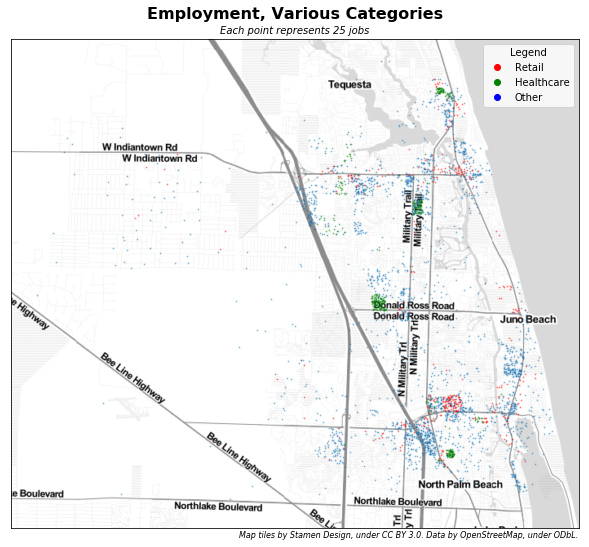

In [23]:
fig, ax = plt.subplots(figsize=(12,9))
ax.axis('on')      # do show axis as a frame
ax.set_xticks([])  # but no tick marks
ax.set_yticks([])  # one either axis
ax.set_title("Employment, Various Categories", fontweight='bold', fontsize=16, pad=20)
ax = i_points.plot(ax=ax, markersize=1, alpha=0.33, color='red')
ax = j_points.plot(ax=ax, markersize=1, alpha=0.33, color='green')
ax = o_points.plot(ax=ax, markersize=1, alpha=0.33)
legend_elements = [
    Line2D([0], [0], marker='o', lw=0, color='red', label='Retail'),
    Line2D([0], [0], marker='o', lw=0, color='green', label='Healthcare'),
    Line2D([0], [0], marker='o', lw=0, color='blue', label='Other'),
]
ax.legend(handles=legend_elements, title='Legend')
ax.annotate('Each point represents 25 jobs', 
            xy=(0.5, 1.0), xycoords='axes fraction', 
            xytext=(0, 5), textcoords='offset points',
           horizontalalignment='center',
           fontstyle='italic')
ax = add_basemap(ax, zoom=12, url=ctx.sources.ST_TONER_LITE)


Using different colored points helps to highlight important traffic generators, including the 
Scripps Research Institute (green, on Donald Ross Road) and the Gardens Mall (red).